<a href="https://colab.research.google.com/github/mancap314/miscellanous/blob/master/lr_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding optimal learning rate through lr increseasement

The idea is to train a model during 1 epoche, increasing slightly the learning rate after each batch. The range of learning rate values a bit before the loss (or validation metric?) starts to increase will be considered the optimal range for learning rate values

## Building a simple model

Here we build a simple model for classifying mnist images. It will serve as basis for developing this method

First we import some classes and define some constants:

In [0]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

batch_size = 32
num_classes = 10

img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)
num_classes = 10

Then we pre-process the MNIST data:

In [2]:
# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print('X_train.shape (just after loading): {}'.format(X_train.shape))
print('X_test.shape (just after loading): {}'.format(X_test.shape))

X_train = X_train / np.float32(255.0)
X_test = X_test / np.float32(255.0)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

print('{} train samples, {} test samples'.format(X_train.shape[0], X_test.shape[0]))

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

X_train.shape (just after loading): (60000, 28, 28)
X_test.shape (just after loading): (10000, 28, 28)
60000 train samples, 10000 test samples


Here we define a function providing the model:

In [0]:
# Initializers set for better reproducibility
seed = 0
glorot_initializer = tf.keras.initializers.glorot_normal(seed=seed)
he_initializer = tf.keras.initializers.he_uniform(seed=seed)


def get_model_cnn_0():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
               activation='relu',
               input_shape=input_shape,
               kernel_initializer=he_initializer,
               bias_initializer='zeros'))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=he_initializer, bias_initializer='zeros'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer=he_initializer, bias_initializer='zeros'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax', kernel_initializer=glorot_initializer, bias_initializer='zeros'))
  return model

It is a classical model with two successive convolution layers followed by  a max pooling, two dense layers and some dropouts inbetween.

## Finding the optimal learning range

Finding the optimal learning rate range is quite crucial. If the learning rate is too small, then the training takes too much time. If it's too big, then the model "jumps" over local minima:

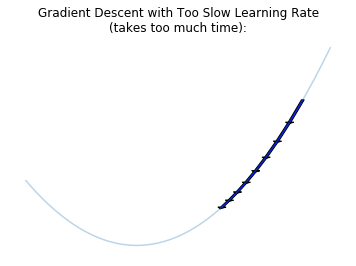

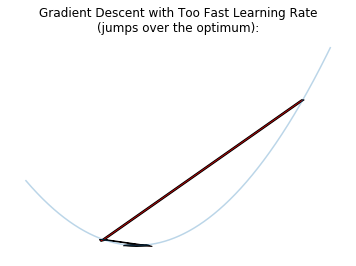

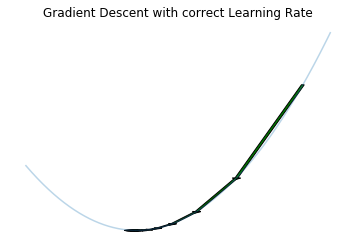

In [6]:
f = lambda x: (x - 2) ** 2 + 1
df = lambda x: 4 * (x - 2)

xx = np.arange(-2, 9, 0.01)
yy = f(xx)


def plot_descent(n_iterations, lr, facecolor, start_x, title=''):
  ax = plt.axes()
  for k in ax.spines.keys():
    ax.spines[k].set_visible(False)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)
  
  ax.plot(xx, yy, alpha=.3)
  current_x = start_x
  # Simple Newton descent algorithm
  for _ in range(n_iterations):
    x, y = current_x, f(current_x)
    dx = -lr * df(current_x)
    dy = f(current_x + dx) - y
    ax.arrow(x, y, dx, dy, width=.1, facecolor=facecolor, fill=True, alpha=1)
    current_x += dx
    
  plt.show()
    
plot_descent(8, .02, 'b', 8, 'Gradient Descent with Too Slow Learning Rate\n(takes too much time):')
plot_descent(10, .3, 'r', 8, 'Gradient Descent with Too Fast Learning Rate\n(jumps over the optimum):')
plot_descent(15, .1, 'g', 8, 'Gradient Descent with correct Learning Rate')
  



The right range of learning rates, we make a first round of training where the learning rate is increased after each batch. The descending slope a bit before the loss reaches its minimum corresponds to the optimal learning rate range.

We define the *optimal slope* as the portion of the loss curve before the *min* where the loss is between $min + 0.05 * (max - min)$ and $min + 0.5 * (max - min)$, and select the corresponding learning rate range, as illustrated here:

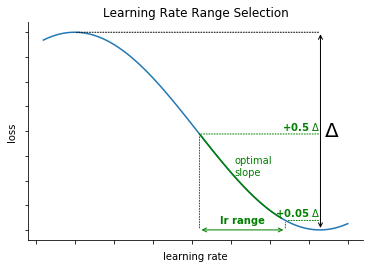

In [7]:
xx = np.arange(-.4, np.pi + .4, 0.05)
yy = np.cos(xx)

amin, amax = np.argmin(yy), np.argmax(yy)
delta = yy[amax] - yy[amin]
amin_lr, amax_lr = np.argmax(yy <= yy[amin] + .05 * delta), np.argmax(yy <= yy[amin] + .5 * delta)
xx_opt, yy_opt = xx[amax_lr: amin_lr], yy[amax_lr: amin_lr]

ax = plt.axes()
ax.plot(xx, yy)
ax.plot(xx_opt, yy_opt, color='g')
ax.annotate('', (xx[amin], yy[amin]), (xx[amin], yy[amax]), arrowprops={'arrowstyle':'<->'})

ax.annotate('', (xx[amax], yy[amax]), (xx[amin], yy[amax]), arrowprops={'arrowstyle':'-', 'linestyle': ':'})

ax.annotate('', (xx[amax_lr], yy[amax_lr]), (xx[amin], yy[amax_lr]), arrowprops={'arrowstyle':'-', 'linestyle': ':', 'color': 'g'})
ax.annotate('', (xx[amin_lr], yy[amin_lr]), (xx[amin], yy[amin_lr]), arrowprops={'arrowstyle':'-', 'linestyle': ':', 'color': 'g'})
ax.annotate('', (xx[amax_lr], yy[amax_lr]), (xx[amax_lr], yy[amin]), arrowprops={'arrowstyle':'-', 'linestyle': ':', 'color': 'g'})
ax.annotate('', (xx[amin_lr], yy[amin_lr]), (xx[amin_lr], yy[amin]), arrowprops={'arrowstyle':'-', 'linestyle': ':', 'color': 'g'})
ax.annotate('', (xx[amin_lr], yy[amin]), (xx[amax_lr], yy[amin]), arrowprops={'arrowstyle':'<->', 'color': 'g'})

ax.text(xx[amin] + .05, (yy[amin] + yy[amax]) / 2, '$\Delta$', horizontalalignment='left', verticalalignment='center', fontsize=20)
ax.text(xx[amin], yy[amax_lr] + .02, '+0.5 $\Delta$', horizontalalignment='right', verticalalignment='bottom', weight='bold', color='g')
ax.text(xx[amin], yy[amin_lr] + .02, '+0.05 $\Delta$', horizontalalignment='right', verticalalignment='bottom', weight='bold', color='g')
ax.text((xx[amin_lr] + xx[amax_lr]) / 2, yy[amin] + .05, 'lr range', horizontalalignment='center', verticalalignment='bottom', weight='bold', color='g')
ax.text((xx[amin_lr] + xx[amax_lr]) / 2 - 0.1, (yy[amin_lr] + yy[amax_lr]) / 2, 'optimal\nslope', horizontalalignment='left', verticalalignment='bottom', color='g')

ax.set_xlabel('learning rate')
ax.set_ylabel('loss')
ax.set_title('Learning Rate Range Selection')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

For this, we define first a  `LrRangeFinder` Keras Callback. This `LrRangeFinder` increases the learning rate used from `start_lr` to `end_lr` batch after batch:



In [0]:
class LrRangeFinder(tf.keras.callbacks.Callback):
  def __init__(self, start_lr, end_lr):
    super().__init__()
    self.start_lr = start_lr
    self.end_lr = end_lr 
       
  def on_train_begin(self, logs={}):
    self.lrs = []
    self.losses = []
    tf.keras.backend.set_value(self.model.optimizer.lr, self.start_lr)
    
    n_steps = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
    n_steps *= self.params['epochs']
    self.by = (self.end_lr - self.start_lr) / n_steps
      

  def on_batch_end(self, batch, logs={}):
    lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
    self.lrs.append(lr)
    self.losses.append(logs.get('loss'))
    lr += self.by
    tf.keras.backend.set_value(self.model.optimizer.lr, lr)

That's just a function to manage the memory while training a model:

In [0]:
def set_session():
    # Empty GPU memory before starting
    tf.keras.backend.clear_session()
    tf.InteractiveSession().close()
    tf.reset_default_graph()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.InteractiveSession(config=config)

No we run a training with a `LrRangeFinder` over one epoch.  We take `start_lr=0.1` and  `end_lr=2`. This range is quite reasonable as we use an `Adadelta` optimizer. 

In [36]:
set_session()

epochs = 1
lrRangeFinder = LrRangeFinder(start_lr=0.1, end_lr=2)
model_cnn_0 = get_model_cnn_0()
model_cnn_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=tf.keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

model_cnn_0.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[lrRangeFinder])

print('{} batches recorded'.format(len(lrRangeFinder.losses)))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


60000/60000 [==============================] - 26s 429us/sample - loss: 0.2658 - acc: 0.9184
1875 batches recorded


How does the loss look like?

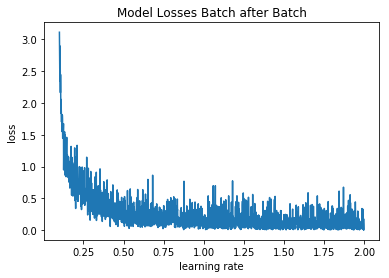

In [37]:
plt.plot(lrRangeFinder.lrs, lrRangeFinder.losses)
plt.title('Model Losses Batch after Batch')
plt.ylabel('loss')
plt.xlabel('learning rate')
plt.show()

The curve is very shaky. Let's smooth it:

In [0]:
def smooth(y, box_pts):
  """smoothes an array by taking the average of the `box_pts` point around each point"""
  box = np.ones(box_pts)/box_pts
  y_smooth = np.convolve(y, box, mode='same')
  return y_smooth

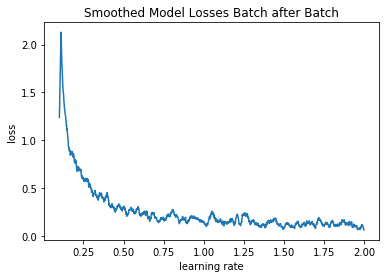

In [38]:
smoothed_losses = smooth(lrRangeFinder.losses, 20)

plt.plot(lrRangeFinder.lrs, smoothed_losses)
plt.title('Smoothed Model Losses Batch after Batch')
plt.ylabel('loss')
plt.xlabel('learning rate')
plt.show()

We sub-sample the (smoothed) losses between the point where it reaches its max and the point where it reaches its min:

In [0]:
min_ = np.argmin(smoothed_losses)
max_ = np.argmax(smoothed_losses)

smoothed_losses_ = smoothed_losses[min_: max_]

Now we take the difference between two successive points of those (smoothed) losses:

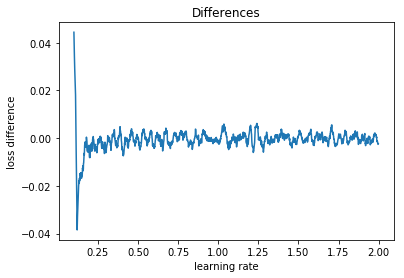

In [40]:
smoothed_diffs = smooth(np.diff(smoothed_losses), 20)

plt.plot(lrRangeFinder.lrs[:-1], smoothed_diffs)
plt.title('Differences')
plt.ylabel('loss difference')
plt.xlabel('learning rate')
plt.show()

In [41]:
min_ = np.argmax(smoothed_diffs <= 0)  # where the (smoothed) loss starts to decrease
max_ = np.argmax(smoothed_diffs >= 0)  # where the (smoothed) loss restarts to increase
max_ = max_ if max_ > 0 else smoothed_diffs.shape[0]  # because max_ == 0 if it never restarts to increase

smoothed_losses_ = smoothed_losses[min_: max_]  # restrain the window to the min_, max_ interval
# Take min and max loss in this restrained window
min_smoothed_loss_ = min(smoothed_losses_[:-1])
max_smoothed_loss_ = max(smoothed_losses_[:-1])
delta = max_smoothed_loss_ - min_smoothed_loss_


lr_arg_max = np.argmax(smoothed_losses_ <= min_smoothed_loss_ + .05 * delta)
lr_arg_min = np.argmax(smoothed_losses_ <= min_smoothed_loss_ + .5 * delta)

lr_arg_min += min_
lr_arg_max += min_

lrs = lrRangeFinder.lrs[lr_arg_min: lr_arg_max]
lr_min, lr_max = min(lrs), max(lrs)

print('lr range: [{}, {}]'.format(lr_min, lr_max))


lr range: [0.15573343634605408, 0.6624026894569397]


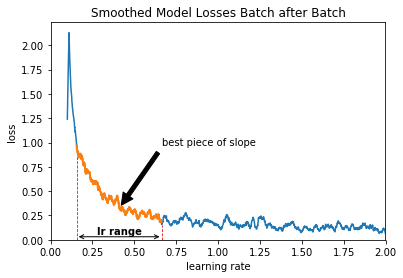

In [42]:
ax = plt.axes()
ax.plot(lrRangeFinder.lrs, smoothed_losses)
ax.set_title('Smoothed Model Losses Batch after Batch')
ax.set_ylabel('loss')
ax.set_xlabel('learning rate')
ax.set_ylim(0, 1.05 * np.max(smoothed_losses))
ax.set_xlim(0, max(lrRangeFinder.lrs))
ax.vlines(x=[lr_min, lr_max], ymin=[0, 0], ymax=[smoothed_losses[lr_arg_min], smoothed_losses[lr_arg_max]], color='r', linestyle='--', linewidth=.8)
ax.plot(lrs, smoothed_losses[lr_arg_min: lr_arg_max], linewidth=2)
x_arrow_arg = int((lr_arg_min + lr_arg_max) / 2)
x_arrow = lrRangeFinder.lrs[x_arrow_arg]
y_arrow = smoothed_losses[x_arrow_arg]
ax.annotate('best piece of slope', xy=(x_arrow, y_arrow), xytext=(lr_max, smoothed_losses[lr_arg_min]), arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate ('', (lr_min, smoothed_losses[lr_arg_max] / 5), (lr_max, smoothed_losses[lr_arg_max] / 5), arrowprops={'arrowstyle':'<->'})
ax.text((lr_min + lr_max) / 2, 3 * smoothed_losses[lr_arg_max] / 5, 'lr range', horizontalalignment='center', verticalalignment='center', weight='bold')

plt.show()

### Cyling learning rate scheduler
We define a learning rate scheduler decreasin the learning rate from `lr_max` to `lr_min` cosine-wise. The amplitude of this cosine function decreases cycle after cycle by a factor `lr_decay` whereas the cycle length is increased after each cycle by a factor `mult_factor`, as illustrated here:

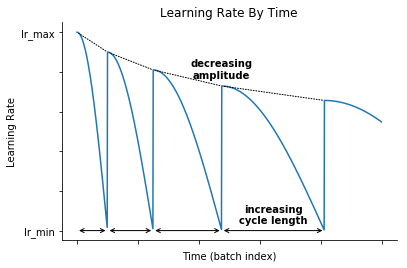

In [22]:
cycle_length = 100
cycle_factor = 1.5
amplitude = 1
decay_rate = .9
xx = np.arange(0, 100, .1)
yy, xs_amplitude, ys_amplitude = [], [0], [amplitude]

j = 0
for i in range(xx.shape[0]):
  if j > 0 and j % cycle_length == 0:
    cycle_length = int(cycle_factor * cycle_length)
    amplitude *= decay_rate
    j = 0
    xs_amplitude.append(xx[i])
    ys_amplitude.append(amplitude)
  
  y = amplitude * np.cos(np.pi / (2 * cycle_length) * j)
  yy.append(y)
  j += 1
  
  
ax = plt.axes()
ax.set_title('Learning Rate By Time')
ax.set_xlabel('Time (batch index)')
ax.set_ylabel('Learning Rate')
ax.plot(xx, yy)

for i in range(len(xs_amplitude) - 1):
  ax.annotate ('', (xs_amplitude[i], 0), (xs_amplitude[i+1], 0), arrowprops={'arrowstyle':'<->'})
  ax.annotate('', (xs_amplitude[i], ys_amplitude[i]), (xs_amplitude[i+1], ys_amplitude[i+1]), arrowprops={'arrowstyle':'-', 'linestyle': ':'})
  
ax.text((xs_amplitude[-1] + xs_amplitude[-2]) / 2, .08, 'increasing\ncycle length', horizontalalignment='center', verticalalignment='center', weight='bold')
ax.text(xs_amplitude[-2], ys_amplitude[-2] + 0.03, 'decreasing\namplitude', horizontalalignment='center', verticalalignment='bottom', weight='bold')


ax.set_xticklabels([])
ax.set_yticklabels(['', 'lr_min', '', '', '', '', 'lr_max'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
    

Here the implementation

In [0]:
class SGDRScheduler(tf.keras.callbacks.Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        self.steps_per_epoch = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

Now we train the model according to this scheduler.

We take 10% of the training data as validation data, saving the model state each time the model reaches a new loss minimum (`ModelCheckpoint()`) and stopping the training if the minimum reached has no been beaten for 10 epochs (`EarlyStopping`)

In [51]:
scheduler = SGDRScheduler(min_lr=lr_min, max_lr=lr_max, lr_decay=.9, cycle_length=3, mult_factor=1.5)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_with_cycling.h5', monitor='val_loss', save_best_only=True),
            scheduler]

set_session()
epochs = 100

model_cnn_0 = get_model_cnn_0()
model_cnn_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=tf.keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

history_with_optimization = model_cnn_0.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 29s 544us/sample - loss: 0.2177 - acc: 0.9343 - val_loss: 0.0507 - val_acc: 0.9847
Epoch 2/100
54000/54000 [==============================] - 29s 539us/sample - loss: 0.0827 - acc: 0.9756 - val_loss: 0.0423 - val_acc: 0.9883
Epoch 3/100
54000/54000 [==============================] - 29s 537us/sample - loss: 0.0620 - acc: 0.9817 - val_loss: 0.0401 - val_acc: 0.9882
Epoch 4/100
54000/54000 [==============================] - 29s 537us/sample - loss: 0.0648 - acc: 0.9801 - val_loss: 0.0372 - val_acc: 0.9882
Epoch 5/100
54000/54000 [==============================] - 29s 535us/sample - loss: 0.0546 - acc: 0.9836 - val_loss: 0.0415 - val_acc: 0.9882
Epoch 6/100
54000/54000 [==============================] - 29s 544us/sample - loss: 0.0485 - acc: 0.9851 - val_loss: 0.0356 - val_acc: 0.9898
Epoch 7/100
54000/54000 [==============================] - 29s 543us/sample - loss: 0.0424 - acc: 0

In [0]:
from sklearn.metrics import accuracy_score

y_true = np.argmax(y_test, axis=1)

In [52]:
model_cnn_0.load_weights('best_model_with_cycling.h5')
predictions = model_cnn_0.predict(X_test)
predictions = np.argmax(predictions, axis=1)
acc = accuracy_score(y_true, predictions)
print('Accuracy on the validation data with cycling learning rates: {}'.format(acc))

Accuracy on the validation data with cycling learning rates: 0.9915


Here we define a function to plot the history of the accuracy and of the loss during the model training, on both the training and the validation data (we will use it later):

In [0]:
import matplotlib.pyplot as plt


def plot_model_history(model_history):
  # summarize history for accuracy
  plt.plot(model_history.history['acc'])
  plt.plot(model_history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

Let's check how the model performed during the training:

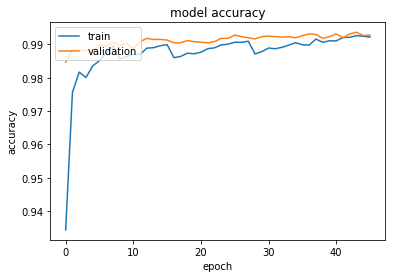

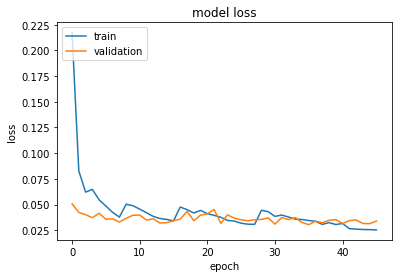

In [53]:
plot_model_history(history_with_optimization)

### Comparing performance without cycling learning rates
Now we train exactly the same model, with the same parameters, just without cycling learning rates:

In [46]:
set_session()
epochs = 100

model_cnn_0 = get_model_cnn_0()
model_cnn_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=tf.keras.optimizers.Adadelta(),
                    metrics=['accuracy'])

history_no_optimization = model_cnn_0.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_without_cycling.h5', monitor='val_loss', save_best_only=True)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 26s 486us/sample - loss: 0.2035 - acc: 0.9389 - val_loss: 0.0467 - val_acc: 0.9885
Epoch 2/100
54000/54000 [==============================] - 26s 482us/sample - loss: 0.0805 - acc: 0.9766 - val_loss: 0.0440 - val_acc: 0.9873
Epoch 3/100
54000/54000 [==============================] - 26s 482us/sample - loss: 0.0626 - acc: 0.9816 - val_loss: 0.0444 - val_acc: 0.9890
Epoch 4/100
54000/54000 [==============================] - 26s 480us/sample - loss: 0.0587 - acc: 0.9831 - val_loss: 0.0472 - val_acc: 0.9873
Epoch 5/100
54000/54000 [==============================] - 25s 468us/sample - loss: 0.0527 - acc: 0.9852 - val_loss: 0.0366 - val_acc: 0.9903
Epoch 6/100
54000/54000 [==============================] - 23s 422us/sample - loss: 0.0519 - acc: 0.9851 - val_loss: 0.0356 - val_acc: 0.9915
Epoch 7/100
54000/54000 [==============================] - 23s 430us/sample - loss: 0.0497 - acc: 0

In [47]:
model_cnn_0.load_weights('best_model_without_cycling.h5')
predictions = model_cnn_0.predict(X_test)
predictions = np.argmax(predictions, axis=1)
acc = accuracy_score(y_true, predictions)
print('Accuracy on the validation data without cycling learning rates: {}'.format(acc))

Accuracy on the validation data without cycling learning rates: 0.9895


The misclassification rate on the test data (not used at all during the training) is about 20% better with the cycling learning rate method ( 0.85% vs. 1.05% without this method)

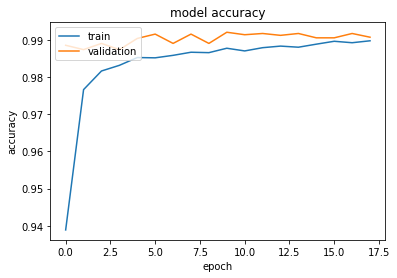

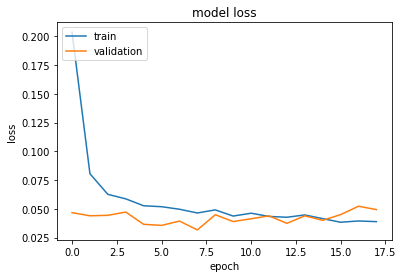

In [50]:
plot_model_history(history_no_optimization)

The cycling learning rate method out-performs the default method on following aspects:
* 20% better misclassification rate
* best validation loss obtained during training: 0.304 vs. 0.317
* best validation accuracy during training: 99.32% vs. 99.20%

The disadvantage of the cycling learning rate is that it took much more time to reach those better performances. With the cycling learning rate, we had to wait until epoch 23 to reach the best performance obtained by the default method (at period 8). In this case, the cycling learning rate moved slower but farer at the end.